In [5]:
from fastaudio.all import *
from fastai.vision.all import *

# Introduction to Audio For FastAI Students

This guide will assume absolutely zero understanding of audio, because it's what we had when starting. There are lots of good resources out there, but nothing that really walks you through the basics of audio all the way up to what it takes to train state of the art models. If you have some experience, or find this guide too slow paced, check out the [FastAI Audio Thread](https://forums.fast.ai/t/deep-learning-with-audio-thread/38123) for a list of resources we've found helpful. Full disclosure, We are not an audio engineer. There will be inaccuracies in this guide, please open an issue with any corrections or suggestions and We'll happily change them and credit you here.

Like deep learning, audio processing has many hyperparameters and concepts that can be confusing, but will play an essential role in training models. The goal of this guide is to introduce you to some of them, show you what tweaking them does, and give you a basic understanding of what they represent and why they exist. If you don't care about the details, check out our **Training Tutorial** notebook. After that see the **Features** notebook to view what the library can do.

First let's grab our data.

In [15]:
data_folder = untar_data(URLs.SAMPLE_SPEAKERS10)

The simplest way to listen to an audio file in Jupyter Notebook is Ipython.display.Audio (imported as Audio) providing a string filepath as an argument. PosixPaths won't work.

In [19]:
from IPython.display import Audio
audio_files = get_audio_files(data_folder)
example = audio_files[0]
Audio(str(example))

## Basics of Librosa, Audio Signals, and Sampling

In fastai audio, we use torchaudio for a lot of our operations, but for general audio processing, librosa is a much more mature library and is a good place to start playing around.

To read an audio for processing, just pass in a filepath to librosa.load

In [20]:
import librosa

In [21]:
y, sr = librosa.load(example, sr=None)

Most libraries will pass back a tuple with signal (y) and a sample rate (sr). 

Note the sr=None, librosa has an annoying habit of "resampling" or changing the sample rate automatically, unless you tell it not to. More about resampling is included later 

In [22]:
print("Sample rate  :", sr)
print("Signal Length:", len(y))
print("Duration     :", len(y)/sr, "seconds")

Sample rate  : 16000
Signal Length: 65920
Duration     : 4.12 seconds


Audio is a continuous wave that is "sampled" by measuring the amplitude of the wave at a given time. How many times you sample per second is called the "sample rate" and can be thought of as the resolution of the audio. The higher the sample rate, the closer our discrete digital representation will be to the true continuous sound wave, but there is a point of diminishing returns so bigger isn't always better. Sample rates generally range from 8000-44100 but can go higher or lower. 

In our example, the audio was sampled 16000 times per second, so our data is  a 1 dimensional tensor with length 16000*time in seconds = 52480 samples

Our signal is just a numpy array with the amplitude of the wave

In [23]:
print("Type  :", type(y))
print("Signal: ", y)
print("Shape :", y.shape)

Type  : <class 'numpy.ndarray'>
Signal:  [ 0.          0.          0.         ... -0.00036621 -0.00018311
 -0.00021362]
Shape : (65920,)


IPython.display.Audio also accepts a Numpy array and sample rate as arguments. 

In [24]:
Audio(y, rate=sr)

Before running and listening to the cells below, think about the concept of sampling rate and try to predict what effect the varying sample rates will have

In [25]:
Audio(y, rate=sr/2)

In [26]:
Audio(y, rate=sr*2)

In [27]:
y_new, sr_new = librosa.load(example, sr=sr*2)
Audio(y_new, rate=sr_new)

In [28]:
y_new, sr_new = librosa.load(example, sr=sr/2)
Audio(y_new, rate=sr_new)

## Waveforms. Amplitude vs Magnitude

A waveform is a curve showing the amplitude of the soundwave (y-axis) at time T (x-axis). Let's check out the waveform of our audio clip

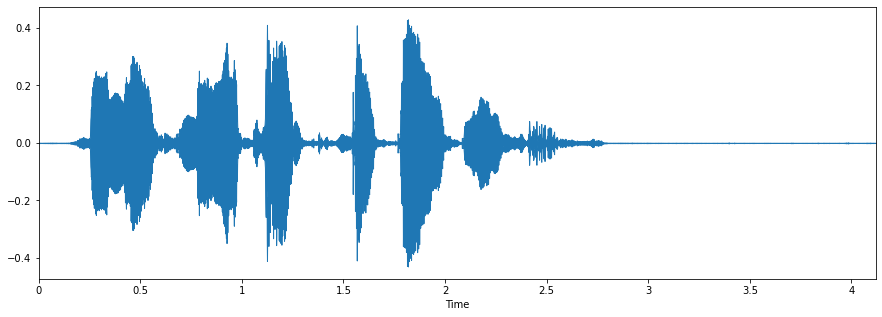

In [29]:
import librosa.display
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y, sr=sr)

Note that there is nothing special about this graph except that the x-axis has been converted to time using our sample rate. If we plotted in matplotlib with plt.plot(y), we would get the same figure, but with sample number on the x-axis instead of seconds.

Amplitude and magnitude are often confused, but the difference is simple. Amplitude of a wave is just the distance, positive or negative, from the equilibrium (zero in our case), and magnitude is the absolute value of the amplitude. In audio we sample the amplitude so our signal can have both positive and negative values.

## Frequency and Pitch

Most of us remember frequency from physics as cycles per second of a wave. It's the same for sound, but really hard to see in the above image. How many cycles are there? How can there be cycles if it's not regular? The reality is that sound is extremely complex, and the above recording of human speech is the combination of many different frequencies added together. To talk about frequency and pitch, it's easier to start with a pure tone, so let's make one. 

Human hearing ranges from 20hz to 20,000hz, hz=hertz=cycles per second. The higher the frequency, the more cycles per second, and the "higher" the pitch sounds to us. To demonstrate, let's make a sound at 500hz, and another at 5000hz. 

In [30]:
# Adapted from https://musicinformationretrieval.com/audio_representation.html
# An amazing open-source resource, especially if music is your sub-domain.
def make_tone(freq, clip_length=1, sr=16000):
    t = np.linspace(0, clip_length, int(clip_length*sr), endpoint=False)
    return 0.1*np.sin(2*np.pi*freq*t)
clip_500hz = make_tone(500)
clip_5000hz = make_tone(5000)

In [31]:
Audio(clip_500hz, rate=sr)

In [32]:
Audio(clip_5000hz, rate=sr)

500 cycles per second, 16000 samples per second, means 1 cycle = 16000/500 = 32 samples, let's see 2 cycles

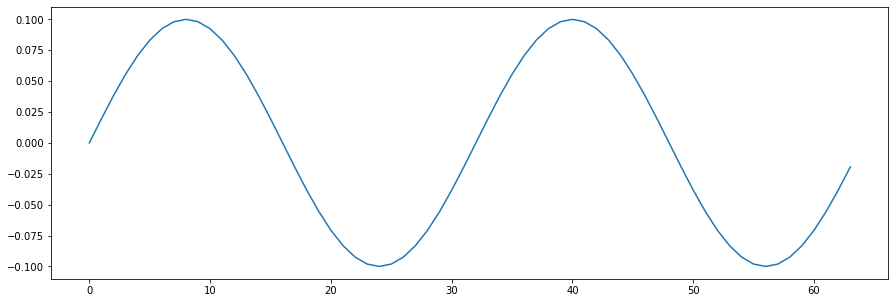

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(clip_500hz[0:64])

Below is 5000hz from the same vantage point, this is what is meant by higher frequency. Of course in real life this is a continuous wave, but since our digital representation is discrete, capturing it starts to break down for high frequencies if we don't increase our sample rate. The limitations of digital representations of audio are laid out by Nyquist Theorem, which we discuss later.

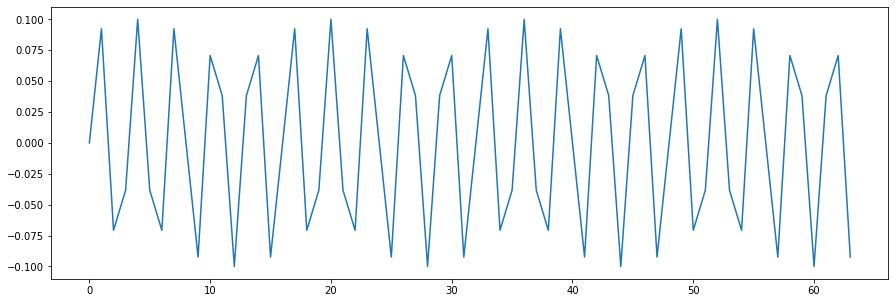

In [34]:
plt.figure(figsize=(15, 5))
plt.plot(clip_5000hz[0:64])

So if that's frequency, what is pitch? Pitch is a musical term that means the human perception of frequency. This concept of human perception instead of actual values seems vague and non-scientific, but it is hugely important for machine learning because most of what we're interested in, speech, sound classification, music...etc are inseparable from human hearing and how it functions. Let's do an experiment and increase the frequency of the above tones by 500hz each and see how much this moves our perception of them

In [35]:
clip_500_to_1000 = np.concatenate([make_tone(500), make_tone(1000)])
clip_5000_to_5500 = np.concatenate([make_tone(5000), make_tone(5500)])

In [36]:
# first half of the clip is 500hz, 2nd is 1000hz
Audio(clip_500_to_1000, rate=sr)

In [37]:
# first half of the clip is 5000hz, 2nd is 5500hz
Audio(clip_5000_to_5500, rate=sr)

Notice that the pitch of the first clip seems to change more even though they were shifted by the same amount. This makes intuitive sense as the frequency of the first was doubled and the frequency of the second only increased 10%. Like other forms of human perception, hearing is not linear, it is logarithmic. This will be important later as the range of frequencies from 100-200hz convey as much information to us as the range from 10,000-20,000hz. If we don't account for this in our data's representation, the lower frequency info will be squished out of existence. 

Fortunately, scientists have thought about this problem and came up with something called the mel scale.

## Mel Scale

The mel scale is a human-centered metric of audio perception that was developed by asking participants to judge how far apart different tones were. Here is a formula from mel-scale's wikipedia page that you will never need, but might like to see.

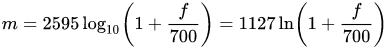

And here is a table of values that represent some examples of frequency in hz and their corresponding mel values. Note: Someone please tell me how to make this table horizontal and maintain the headers :)

<table>
  <tr>
    <th>Frequency</th>
    <td>20</td>
    <td>160</td>
    <td>394</td>
    <td>670</td>
    <td>1000</td>
    <td>1420</td>
    <td>1900</td>
    <td>2450</td>
    <td>3120</td>
    <td>4000</td>
    <td>5100</td>
    <td>6600</td>
    <td>9000</td>
    <td>14000</td>
  </tr>
  <tr>
    <th>Mel Equivalent</th>
    <td>0</td>
    <td>250</td>
    <td>500</td>
    <td>750</td>
    <td>1000</td>
    <td>1250</td>
    <td>1500</td>
    <td>1750</td>
    <td>2000</td>
    <td>2250</td>
    <td>2500</td>
    <td>2750</td>
    <td>3000</td>
    <td>3250</td>
  </tr>
</table>

When we visually represent audio using spectrograms, we will use the mel scale instead of frequency on our y-axis, so that our data is reshaped to mirror human perception. **If you're getting bored, hang in there, because we are so close to the fun part (spectrograms)**, but there is one last piece to human hearing puzzle we need to deal with.


## Decibels

Just like frequency, human perception of loudness occurs on a logarithmic scale. A constant increase in the amplitude of a wave will be perceived differently if the original sound is soft or loud. 

Decibels measure the ratio of power between 2 sounds, with the main idea being that each 10x increase in the energy of the wave (multiplicative) results in a 10dB increase in sound (additive). Thus something that is 20dB louder has 100x (10*10) the amount of energy, something that is 25dB louder has (10^2.5) = 316.23x more energy. 

The lowest audible sound, near absolute silence, is 0dB and we refer to other sounds based on how many times more energy they have than a 0dB sound. A dishwasher is ~30dB, or 10^3 = 1000x louder. Here is a nice chart taken from: https://boomspeaker.com/noise-level-chart-db-level-chart/

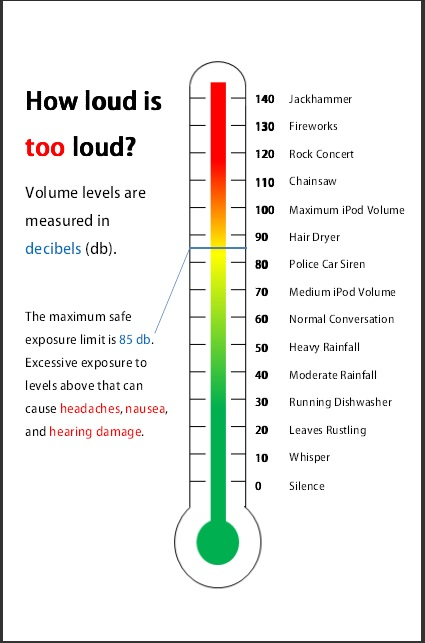

The range of human perception is vast, from a base of 0dB up to 100dB (an amount that will damage your hearing), is a range of 10^10, or 10,000,000,000x. A doubling of energy will only increase the dB level by ~3dB. If we don't use a logarithmic scale, we would squish whispers and rustling leaves, and even normal conversation out of existence. Thus is it is important that we measure our spectrograms be on the decibel scale for most of our applications. 

Deep dive for decibel scale: http://www.animations.physics.unsw.edu.au/jw/dB.htm

## Spectrogram as a Visual Representation of Audio

Remember how it was impossible to see the smooth cycles and frequencies in the raw waveform graph of our first audio clip? A spectrogram is an almost magical way of breaking a complex signal apart into it's constituent frequencies, and then representing that as an image. Before we get into how this actually happens, let's see what they look like and how to generate and play with them, because this is more important for training your models than actually understanding what a fourier transform is and how it works. 

Librosa allows us to generate a spectrogram with the melscale directly using `librosa.feature.melspectrogram`. To demonstrate why the previous discussion of melscale and decibels was necessary, we'll first display a raw spectrogram with `librosa.stft`, then a melspectrogram, and then finally a melspectrogram on the decibel scale. 

sg = spectrogram, this is a raw energy spectrogram. stft = short-time fourier transform. stft returns a complex result with a real component, the magnitude, and a complex part, the phase. The complex part is typically not used in machine learning applications, but there are a few papers that suggest it is useful so you may want to experiment. For now we will discard it.

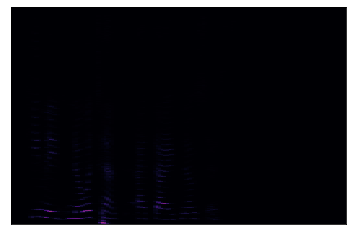

In [39]:
sg0 = librosa.stft(y)
sg_mag, sg_phase = librosa.magphase(sg0)
display(librosa.display.specshow(sg_mag));

Next we use the mel-scale instead of raw frequency. `librosa.feature.melspectrogram` can take either a raw spectrogram and convert to mel-scale, or a raw signal, compute the spectrogram, and then convert. We will use what we generated in the above cell, but usually you'll want to pass the signal directly. 

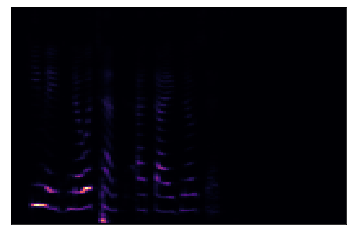

In [40]:
sg1 = librosa.feature.melspectrogram(S=sg_mag, sr=sr)
display(librosa.display.specshow(sg1));

It's a little better, but most of the information is still zeros, and we know our original signal has lots of info, so we must be throwing away too much. Converting to the decibel scale using `librosa.amplitude_to_db` will fix this.

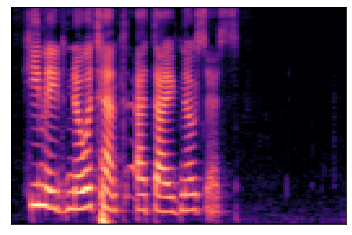

In [41]:
sg2 = librosa.amplitude_to_db(sg1, ref=np.min)
librosa.display.specshow(sg2);

Okay, this is starting to look like reasonable. But what does any of this mean? In the next section, we'll add on some axes and a colorbar legend and then look at the underlying data structure and see what we're dealing with

## What's Inside a Spectrogram?

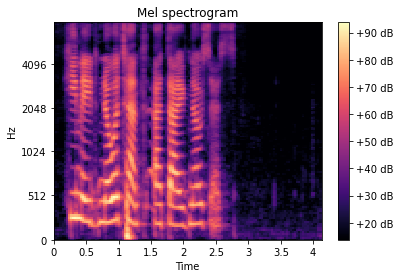

In [43]:
# code adapted from the librosa.feature.melspectrogram documentation
librosa.display.specshow(sg2, sr=16000, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram');

Now we can see, just like when we plotted the audio, the x-axis is time, but now, instead of the amplitude of the wave on the y-axis, we have the frequency. The y-axis is also no longer linear, each new tick doubles the frequency, with a max frequency, or fmax of 8000. Also, this isn't a line graph like the raw waveform, instead of a single value at each timepoint on our x-axis, we have many. Every point in the square represents the energy at the **frequency of it's y-coordinate at the time of it's x-coordinate**. 

Take the point 1.5 seconds in at 1024hz, it appears to be cream colored meaning the energy at that point is somewhere around 80-85db. Meanwhile at that same time, 4096hz appears to be purple and have about 40dB of energy. That means that at t = 1.5 seconds, the sound with 1024hz is around 10000 times louder than sound at 4096hz. 10^((80-40)/10) = 10^4 = 10000.

Let's check out the min, max, and mean of the spectrogram. Remember, the units for these are all decibels. 

In [44]:
sg2.min(), sg2.max(), sg2.mean()

(13.7591095, 93.75911, 33.827404)

So it looks like spectrograms have a built in min, mean, and max, that's nice. Let's see what type of object a spectrogram really is so we can see what else we can do.

In [45]:
print(type(sg2))
sg2.shape

<class 'numpy.ndarray'>


(128, 129)

Spectrograms become a lot less magical and a lot easier to work with when you realize they're just 2d numpy arrays. We no longer have to remember and call random functions like librosa.display.specshow, with a little tinkering (converting to pytorch, and adding a unit axis) we can just use fastai's `TensorImage()`

<AxesSubplot:>

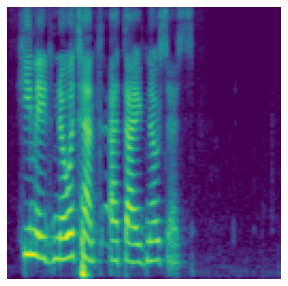

In [50]:
TensorImage(torch.from_numpy(sg2).flip(0).unsqueeze(0)).show(figsize=(15, 5), cmap=None)

`unsqueeze(0)` adds a single axis in pos 0 so we go from 128x103 to 1x128x103. Images in fastai have 3 dimensions, the 
first, a channel dimension 1 for monochrome images, 3 for rgb. This is really black and white data but the `cmap` (colormap)
param displays it to us with color. In `TensorImage.show` it defaults to None, but lower down fastai uses a default colormap
called 'viridis'. Try changing cmap to 'binary', or 'rainbow' or try an option that doesn't exist and matplotlib will give
you an options list in the error message.

## Spectrogram Parameters and How to Fine Tune them for Deep Learning

Remember those hyperparameters mentioned in the intro? Our experiments indicate they matter a lot. If you don't understand your underlying data, you won't be able to create good visual representations of them. In fastai audio, we do our best to give you good default values, but to get the highest accuracy possible out of your models, you'll need to be able to tune it to your exact needs. Let's tune this one and introduce these parameters in the process.

Here's the same spectrogram, but with all default arguments made explicit. 

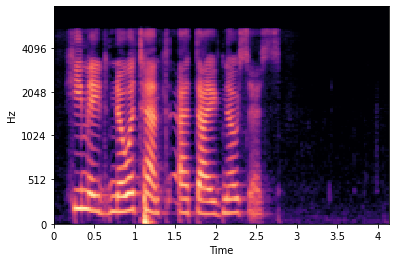

In [52]:
y, sr = librosa.load(example)
display(Audio(y, rate=sr))
sg = librosa.feature.melspectrogram(y, sr=16000,  n_fft=2048, hop_length=512, power=1.0, n_mels=128, fmin=0.0, fmax=None)
db_spec = librosa.amplitude_to_db(sg, ref=1.0, amin=1e-05, top_db=80.0)
librosa.display.specshow(db_spec, y_axis='mel', fmax=8000, x_axis='time')

Before we get into the details, here is a cheatsheet with a brief summary of what each of these do and some good defaults.

## HyperParameter Cheat Sheet

- **`sample_rate`**, This is not the place to change this, you are just telling librosa what your sample rate is. **Usually it is predetermined for you by your dataset but check the resampling section for more info on changing this.**
- **`fmin`**, minimum frequency to display in spectrogram, **this should be low, anything 0-20 seems to work well**
- **`fmax`**, maximum frequency to display. **This should generally be 1/2 of your sample rate, but can be set to 8000 for speech.** 
- **`n_mels`**, How many mel bins to use, this will determine number of pixels tall your sg is. **64-128 are good defaults, but try various values**, bigger isn't always better, test for your dataset. Some evidence suggests upscaling the image to a larger size is more effective than 
- **`n_fft`**, The number of samples you use each time you compute a Fourier Transform. This is the width of the window and hop_length is how much you move the window each step. Increasing n_fft will increase frequency (y-axis) resolution to a point, powers of 2 are faster. Also dependent somewhat on `n_mels` so 20*n_mels is a common value as less than this can produce empty mel bins (black horizontal lines on sg)
- **`hop_length`**, the number of samples between successive frames of your sg. Determines width of image (# samples/hop = width in pixels). Good defaults really depend on dataset and the duration of audio your sg's represent (if they are longer, a larger hop is required to fit on a gpu, but you will be compressing the data). If you go too small, you can get blurring. Anything **64-512 can be good depending on context.**
- **`top_db`**, Distance between loudest and softest sound you want displayed in spectrogram. If you choose 50db, the brightest pixel will be 50db, and anything that is 50+db lower than that won't be displayed. **80-120 is good.**
- **`power`**, Honestly not entirely sure how this works. It's set to 1 for "energy" spectrogram and 2 for "power" spectrogram. An energy spectrogram is more detailed (less energy required to show up on the sg) but you don't generally have to worry about this because if you are converting to decibels (you'll do this almost always) it is factored out. 

As you can see there are loads, and I'm sure it's overwhelming, but the good news is that most models will train just fine with defaults, only a few of these have a big impact, and they are all pretty easy to understand, it will just take time and changing the values to see what effect it has. The bad news is that I've been lying about our starting spectrogram. Matplotlib is stretching this a lot for us, but unless we save the file as a jpg and train on that (slow) we will have small images. So let's use fastai's `TensorImage` to see what this really looks like (hint: it's the same dimensions as the underlying numpy array)

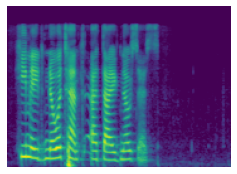

In [55]:
TensorImage(torch.from_numpy(db_spec).flip(0).unsqueeze(0)).show();

One more bit of bad news. The majority of our important spectrogram hyperparameters are inextricably tied to fourier transforms. So, before getting to play with all the hyperparams and train world class models in audio, we need a basic understanding of what fourier transforms are doing. 

## The Details

This is the point where we really start getting in the weeds. Spend time here if you're going to spend a lot of time in the audio world, but if you just have one project in mind, you might be better off just using the audio library to see if you can get good results first.

## Fourier Transforms

Remember a spectrogram is taking a complex signal (the raw waveform) and cracking it open so that instead of the amplitude of the signal at time t, we can see the magnitude of each frequency at time t. Behind this decomposition is the fourier transform. Because it is such an important operation in science, and also so difficult to wrap your head around, many other people have done a better job explaining it than I ever could. 

Here is one such video: [3Blue1Brown: A Visual Introduction to the Fourier Transform](https://www.youtube.com/watch?v=spUNpyF58BY)

Let's reboot our tone generator, add some signals together, and see if the fourier transform can take them apart for us.

In [63]:
# Adapted from https://musicinformationretrieval.com/audio_representation.html
# An amazing open-source resource, especially if music is your sub-domain.
def make_tone(freq, clip_length=1, sr=16000):
    t = np.linspace(0, clip_length, int(clip_length*sr), endpoint=False)
    return 0.1*np.sin(2*np.pi*freq*t)

In [64]:
def add_3_random_tones(clip_length=1, sr=16000):
    tone_list = []
    for i in range(3):
        frequency = random.randint(500,8000)
        tone_list.append(make_tone(frequency, clip_length, sr))
        print(f"Frequency {i+1}: {frequency}")
    return sum(tone_list)

In [65]:
sr = 16000
signal = add_3_random_tones(sr=sr)

Frequency 1: 6290
Frequency 2: 6004
Frequency 3: 2396


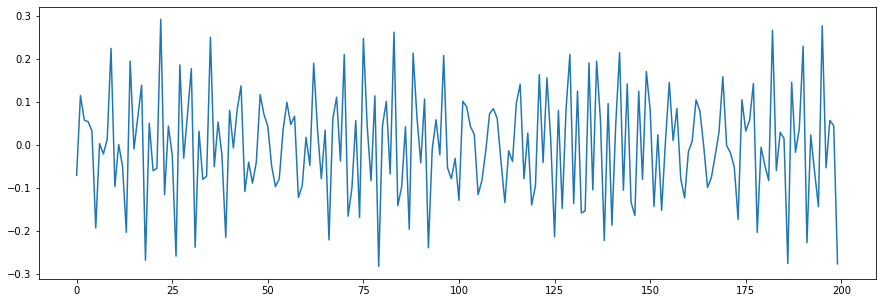

In [66]:
display(Audio(signal, rate=sr))
plt.figure(figsize=(15, 5))
plt.plot(signal[200:400]);

To use 3Blue1Brown's analogy, we've mixed together 3 colors of paint, and it seems impossible to separate them, but if we do a fourier transform using `scipy.fft`. Don't worry about understanding the code below, you will not need to do manually fourier transforms. The only things worth noting are that the FT output is complex with a real component (magnitude) and an imaginary one (phase) and we only capture the real. Also fourier transforms output symmetric data so we are only taking the first half. 

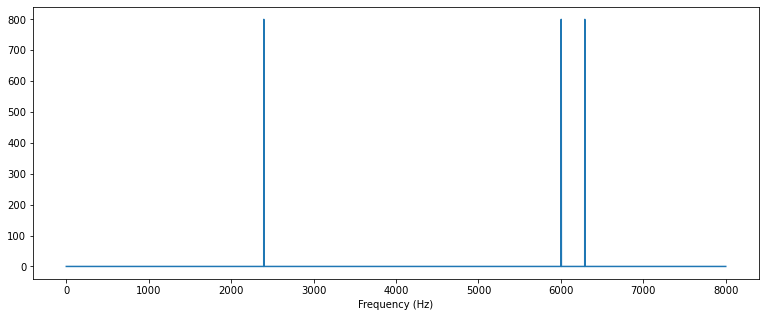

In [67]:
# Code adapted from https://musicinformationretrieval.com/fourier_transform.html and the original
# implementation of fastai audio by John Hartquist at https://github.com/sevenfx/fastai_audio/
def fft_and_display(signal, sr):
    ft = scipy.fftpack.fft(signal, n=len(signal))
    ft = ft[:len(signal)//2+1]
    ft_mag = np.absolute(ft)
    f = np.linspace(0, sr/2, len(ft_mag)) # frequency variable
    plt.figure(figsize=(13, 5))
    plt.plot(f, ft_mag) # magnitude spectrum
    plt.xlabel('Frequency (Hz)')
    
fft_and_display(signal, sr)

And like magic, it spits out the 3 components we put in. This will work for arbitrarily complex signals. Even if we mix a bunch of frequencies together, when we break them apart with the fft, we can see each individual input. 

In [68]:
for i in range(5):
    signal += add_3_random_tones(sr=sr)

Frequency 1: 6821
Frequency 2: 3968
Frequency 3: 2575
Frequency 1: 4462
Frequency 2: 3948
Frequency 3: 5678
Frequency 1: 4872
Frequency 2: 7700
Frequency 3: 3641
Frequency 1: 6463
Frequency 2: 5671
Frequency 3: 5328
Frequency 1: 4595
Frequency 2: 4543
Frequency 3: 5716


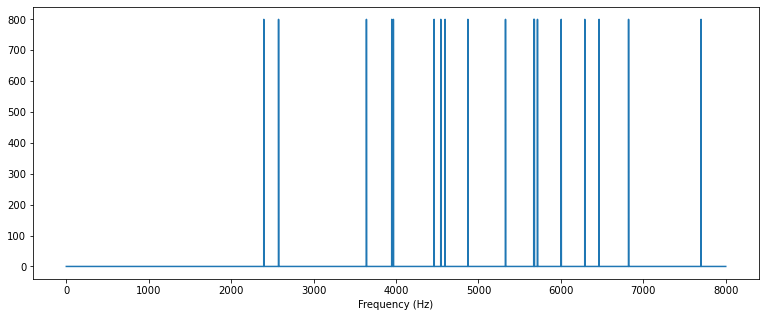

In [69]:
fft_and_display(signal, sr)

Let's try a fourier transform on our example speech clip.

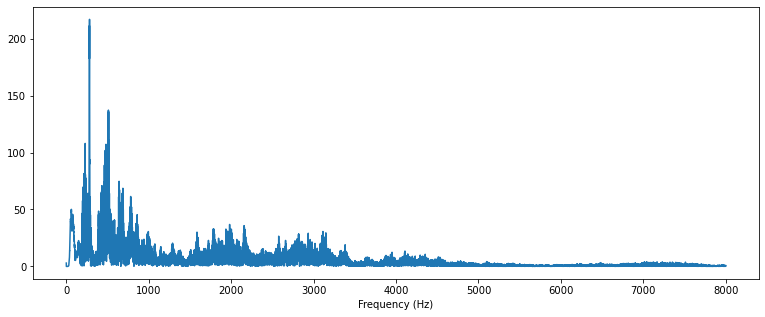

In [70]:
y, sr = librosa.load(example, sr=16000)
fft_and_display(y, sr)

This signal looks impossibly complex, even when decomposed, but that's because we are adding up the energy at each frequency for the entire 3 seconds of the clip. Looking at the above image is the same as listening to a 3 second clip in an instant. We've lost our time component and are now purely in the frequency domain. 

To illustrate the limitations of the fourier transform in a different way, let's take two 1s long signals, s1 and s2, and add them so we have a new 1 sec long clip, and then let's take those same 1s signals and concatenate them, so that we have a different 2 second long clip composed of 2 distinct signals. 

In [71]:
s1 = add_3_random_tones(sr=sr)
s2 = add_3_random_tones(sr=sr)
s1_plus_s2 = np.add(s1, s2)
s1_then_s2 = np.concatenate([s1, s2])
display(Audio(s1_plus_s2, rate=sr))
display(Audio(s1_then_s2, rate=sr))

Frequency 1: 4666
Frequency 2: 1505
Frequency 3: 3047
Frequency 1: 7508
Frequency 2: 1155
Frequency 3: 6819


Now let's look at their Fourier transforms. Even though the signals are totally different, their FTs are the same. 

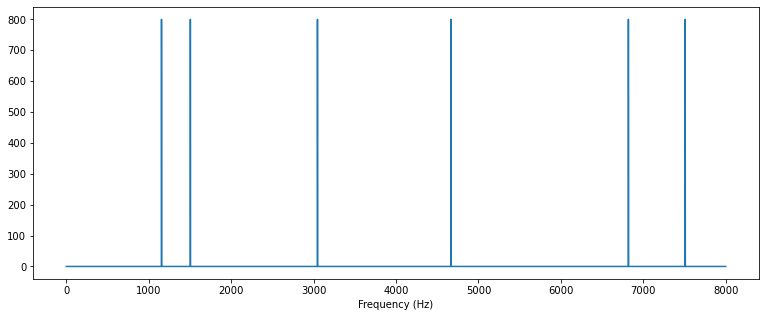

In [72]:
fft_and_display(s1_plus_s2, sr)

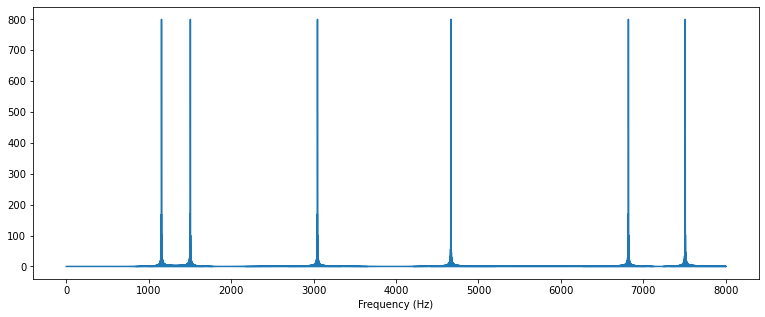

In [73]:
fft_and_display(s1_then_s2, sr)

Most everything we are interested in for deep learning, noise, speech, music...etc is going to have frequencies that change over time. In speech that means from phoneme to phoneme and word to word. If we just add it all together we get a meaningless jumble of information. 

Remember that the end result of our spectrogram had both time and frequency information. The color of the image at pixel (x,y) represented the magnitude of frequency y at time x. The raw signal/waveform has all time and no frequency. The fourier transform has all frequency and no time. We need something in between. 

What we really want to do is compute the fourier tranform at different points in time so that we can see the breakdown of frequencies of the sound at that time. The way to do this is through the short-time fourier transform, or STFT we saw earlier. 

 ## Short-Time Fourier Transform

The main idea behind the short-time fourier transform is that, instead of doing an FT on the entire signal, we break the signal up into chunks, and compute the FT of each chunk to see how the frequencies of the signal are changing over time. 

The demonstration below allows us to distinguish between the signals above in a way that a normal fourier transform could not. Don't worry about understanding code here, we will break it down later to learn what everything does.

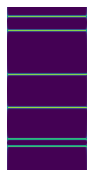

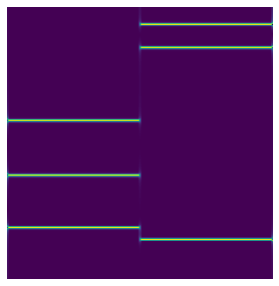

In [91]:
def stft_and_display(signal, n_fft=512, hop_length=128, to_db_scale=False, n_mels=128, mel_scale=False, 
                     top_db=80, show_shape=False):
    stft = librosa.stft(signal, n_fft, hop_length)
    real_portion = abs(stft)
    if(mel_scale):   real_portion = librosa.feature.melspectrogram(S=real_portion, n_fft=n_fft, n_mels=n_mels)
    if(to_db_scale): real_portion = librosa.amplitude_to_db(real_portion, top_db)
    if(show_shape):  print("Shape: {}x{}".format(*real_portion.shape))
    TensorImage(torch.from_numpy(real_portion).flip(0).unsqueeze(0)).show()
    plt.show()
    
display(Audio(s1_plus_s2, rate=sr))    
stft_and_display(s1_plus_s2)

display(Audio(s1_then_s2, rate=sr))    
stft_and_display(s1_then_s2)

To understand exactly what is happening inside the STFT, let's start playing with our first spectrogram parameters, n_fft, and hop_length. 

## n_fft and hop_length 

The best way to understand what changes will happen as you mess with these variables, is to mess with these variables and see what happens. First at a base level by looking at the spectrograms and trying to understand and then actually try training one of the audio datasets, but seeing how changing a variable like n_fft or hop_length (while keeping everything else the same) impacts training, in the same way that you do with normal ML hyperparams like learning rate or image_size.

n_fft = 100


n_fft = 600


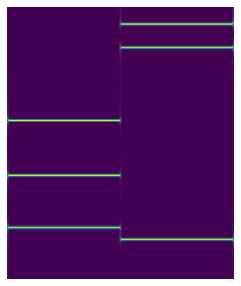

n_fft = 1100


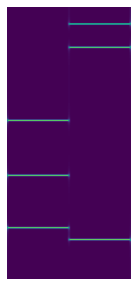

n_fft = 1600


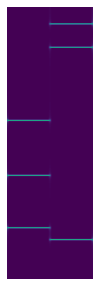

In [92]:
for n_fft in range(100, 2100, 500):
    print("n_fft =", n_fft)
    stft_and_display(s1_then_s2, n_fft=n_fft)

The n_fft is making our images taller, and more spaced out, but the bars for an individual frequency remain the same size. Thus when we increase n_fft in our stft, we have more resolution in the frequency dimension, and can distinguish between more possible frequencies. If we set the n_fft too low, they all get smashed together. Let's try again with our real world speech data, this time narrowing the range to lower values so we can more easily see the impact

n_fft = 50


n_fft = 250


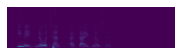

n_fft = 450


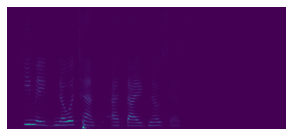

n_fft = 650


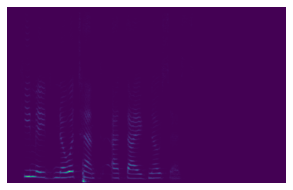

n_fft = 850


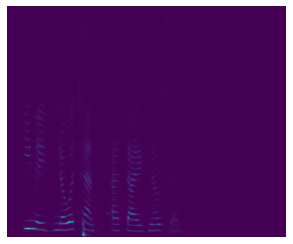

In [93]:
y, sr = librosa.load(example, sr=16000)
for n_fft in range(50, 1050, 200):
    print("n_fft =", n_fft)
    stft_and_display(y, n_fft=n_fft)

Since real speech has more frequencies, having too low an n_fft causes us to lose info about which frequencies are present. It looks like around an n_fft of 350-450, we aren't losing any info, but if we reshape the data to mimic human hearing, converting again to the mel scale for frequency, and decibels for loudness, it becomes clear we weren't getting the whole picture (and neither was our image classifier that will be learning from these spectrograms)

n_fft = 50


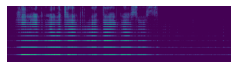

n_fft = 250


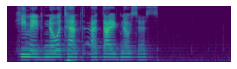

n_fft = 450


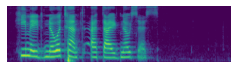

n_fft = 650


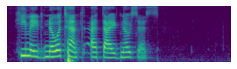

n_fft = 850


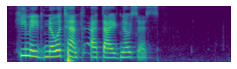

In [94]:
for n_fft in range(50, 1050, 200):
    print("n_fft =", n_fft)
    stft_and_display(y, n_fft=n_fft, mel_scale=True, to_db_scale=True)

Notice that our images are no longer ballooning in length as we increase n_fft. In fact, they aren't changing at all. This is due to the way melspectrograms are constructed, and somethign we'll cover later in the 'n_mels' section. If you go back and try it again with `mel_scale`=False, you'll see that they still stretch, but what appears to be additional information that we are losing on the mel_scale is actually information that is disproportionately unimportant to discriminating between sounds that we care about. 

Yes, we will lose the ability to differentiate between an 8050hz sound and an 8060hz sound, but this is an ability that humans don't have and will never impact your models accuracy on a human-centric problem like speech-recognition. That being said, keep in mind that if your application does depend on being able to differentiate between sounds in a way that a human cannot, the mel-scale might not be a good idea.

Now we do the same with hop_length, using an n_fft of 850. 

hop_length = 50


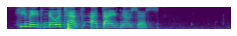

hop_length = 150


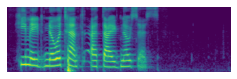

hop_length = 250


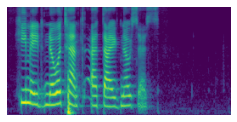

hop_length = 350


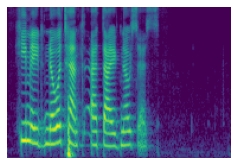

hop_length = 450


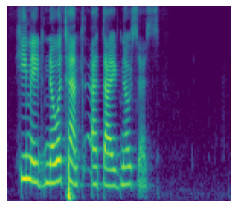

In [95]:
for hop_length in range(50, 550, 100):
    print("hop_length =", hop_length )
    stft_and_display(y, n_fft=850, hop_length=hop_length, mel_scale=True, to_db_scale=True)

So hop_length does something to alter the width of the spectrogram. This is good to know, but since image size can be really important to training, I'm going to show you exactly how you can control the width of your spectrogram images.

Sig length   : 65920
hop_length   : 100
SigLen/HopLen: 659.2
Floor + 1    : 660
Shape: 128x660


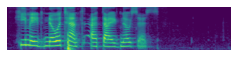

Sig length   : 65920
hop_length   : 200
SigLen/HopLen: 329.6
Floor + 1    : 330
Shape: 128x330


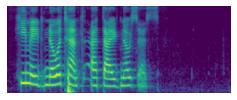

Sig length   : 65920
hop_length   : 300
SigLen/HopLen: 219.73333333333332
Floor + 1    : 220
Shape: 128x220


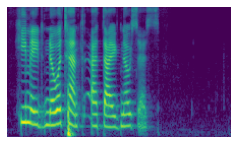

Sig length   : 65920
hop_length   : 400
SigLen/HopLen: 164.8
Floor + 1    : 165
Shape: 128x165


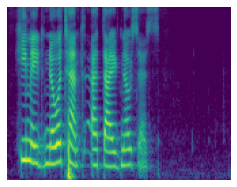

In [96]:
for hop_length in range(100, 500, 100):
    print("Sig length   :", len(y))
    print("hop_length   :", hop_length)
    print("SigLen/HopLen:", len(y)/hop_length)
    print("Floor + 1    :", int(len(y)/hop_length)+1)
    stft_and_display(y, n_fft=850, hop_length=hop_length, mel_scale=True, to_db_scale=True, show_shape=True)

I don't have fancy LaTeX for this but the python version is 

`spectrogram_width = math.floor(len(signal)/hop)+1`

also keeping in mind that

`len(signal) = duration*sample_rate #duration in seconds`

With this, you can take any length signal (fastai audio has built in features to remove silence, segment, and pad signals to a fixed length) and 


## Full explanation of STFT, hop_length, and n_fft

Special thanks to [Tom B from the forums](https://forums.fast.ai/u/TomB) for pointing out numerous errors in my original. You can read his post [here](https://forums.fast.ai/t/deep-learning-with-audio-thread/38123/265)

Feel free to skip this, especially if audio is new to you.

Remember how we wanted to split a signal into chunks, and then compute the fourier transform of each chunk to see how the frequencies were changing over time? The STFT is taking your signal and splitting it into overlapping chunks based on `hop_length` and `n_fft`. The most common analogy for this is a sliding window. Imagine a window that is n samples wide. At the start, the window covers samples 0-n and computes a fourier transform on them. Next it slides h pixels over, and repeats the FT on samples h to n+h. It again slides over h and repeats on samples 2*h through n+2*h and so on until we reach the end of the signal. n is `n_fft`, and represents the the width of our window and the width of each chunk (in number of samples), and h is `hop_length`, and how how many samples we shift to the right each time. If you set hop_length to 100 and n_fft to 1024, the STFT will divide your 52,480 sample long signal into 525 (ceil(52480/100)) chunks that are 1024 samples wide, compute the FFT (fast fourier transform, just an algorithm for computing the FT of a discrete signal) of each one of those chunks. 

There is also another different type of window, one that is windowed across the n_fft samples when computing an fft, that I don't fully understand and may add in the future when I do. By default it is set to n_fft so things will behave as described above, but if you want to understand more, please click the link above and check out the [notebook](https://nbviewer.jupyter.org/gist/thomasbrandon/f0d11593b07dc5ccb2237aec6b4355a5) @TomB created to demonstrate the difference.

The output of each FFT will be a 1D tensor with (n_fft/2)+1 = 513 values, each value is the magnitude of the energy for a particular range of frequencies, at that chunk of time. For example, if our min and max frequencies (something we havent covered yet) are set to 0hz and 8000hz, for simplicity let's imagine our n_fft is 100, every FFT will chop that frequency range into 100 baskets, 0-80hz, 80-160hz, 160-240hz...7920hz-8000hz, and will then perform an fft on each chunk of 100 samples, and will return a 1D tensor where the first value is the magnitude of the energy in the 0-80hz range for the first 100 samples, the second value is the energy in the 80-160hz range for the first 100 samples and so on. That tensor is then rotated and becomes the first column of our STFT image. If you are not using the mel_scale, you will have n_fft as the height of your images, but if you are using the mel-scale, the height of your image will be determined by the number of mel filters you use, the parameter `n_mels`, something that is much simpler than it sounds, and that we will discuss next.

## n_mels

Each melspectrogram in the last section was 128 pixels tall. That's because, by default, we set n_mels to 128. Let's try with `n_mels` what we did for n_fft and hop_length to see what effect it has. 

A random tip is that n_fft will be fastest when it is a power of 2 and slowest when it's prime, so convention is to just use powers of 2. Let's set that to 2^10 = 1024. What should our hop be? Let's do 2^8 = 256 for now until we figure out what impact n_mels has. 

n_mels = 50
Shape: 50x258


n_mels = 300
Shape: 300x258


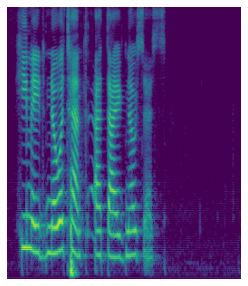

n_mels = 550
Shape: 550x258


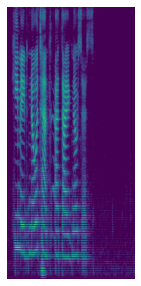

n_mels = 800
Shape: 800x258


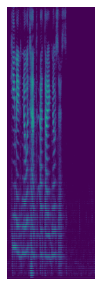

In [97]:
for n_mels in range(50, 1050, 250):
    print("n_mels =", n_mels)
    stft_and_display(y, n_fft=1024, hop_length=256, n_mels=n_mels, mel_scale=True, to_db_scale=True, show_shape=True)

So the height in pixels of our image is always equal to n_mels when we compute a mel-spectrogram(and is equal to n_fft when we don't use the mel scale). If you scroll down, you'll see that we have a lot of black bars when we have too many mels. This is because when librosa converts a spectrogram to the melscale, there are points where it doesn't have enough data from the linear scaled fft buckets to fill in the logarithmically scaled mel buckets. If we increase n_fft, they will go away, but not without a cost. 

n_mels = 50
Shape: 50x258


n_mels = 300
Shape: 300x258


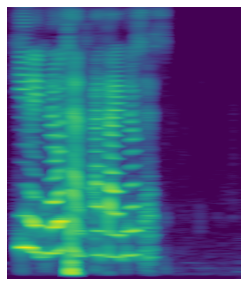

n_mels = 550
Shape: 550x258


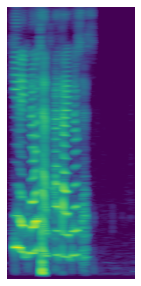

n_mels = 800
Shape: 800x258


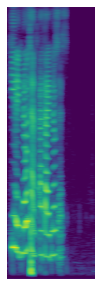

In [98]:
for n_mels in range(50, 1050, 250):
    print("n_mels =", n_mels)
    stft_and_display(y, n_fft=8192, hop_length=256, n_mels=n_mels, mel_scale=True, to_db_scale=True, show_shape=True)

When we increase resolution in the frequency dimension (y-axis), we lose resolution in the time dimension, so there is an inherent tradeoff between the choices you make for n_fft, n_mels, and your hop_length. This is getting to the limits of my understanding, so if you feel you can explain this precisely, message me or post in the [FastAI Audio Thread](https://forums.fast.ai/t/deep-learning-with-audio-thread/38123/).

Thanks to Tom B explaining this in a bit more detail: 
"This is true of the FFT where the choice of n_fft trades off temporal resolution for frequency resolution as it determines both. You have n_fft//2 frequency bins, but your spatial resolution is limited to sample_rate/n_fft, e.g. 16000/1024=15.625 means a temporal resolution of 15.6 milliseconds. But this is why you use the STFT. This separates temporal resolution, determined by hop_length, from frequency resolution, set by n_fft.
There’s still a bit of a tradeoff as while you get an FFT every hop_length samples it is still giving you frequencies over the next n_fft samples not just those hop_length samples, but it isn’t the direct tradeoff of the FFT. And using a window function will balance this out a bit, reducing the sort of temporal smearing a larger n_fft will give without a window function. So you are correct that there is still a tradeoff but it’s not the simple frequency resolution vs. time-resolution of a standard FFT. Thus you see that when you raised n_fft from 1024 to 8192 you still got the same 206 time values based off your hop_length."

If not, just know that you can control the height of your images by setting the number of mel filters via the `n_mels` argument to `librosa.feature.melspectrogram` or if you are using fastai audio, setting the n_mels parameter in your spectrogram config. 

## top_db 

`top_db` is a threshhold for the softest sound you want displayed in the spectrogram (relative to your loudest sound). If you choose 50db, the brightest pixel will be 50db, and anything that is 50+db lower will be represented by a 0. The default value is set to 80 in librosa but we've found that higher can be better (usually 100), with up to 120-130 still getting good results, so this is a good value to add to your grid search to see if it affects your results. Keep in mind that if you are doing voice recognition work, setting top_db to a high value increases the likelihood that you pick up distinct background noise or microphone artifacts that increase your validation accuracy, but aren't actually improving the ability of your model to generalize and identify voices, but instead are learning to identify the speaker's device.

## How to Contribute

We are not audio experts. If you spot a mistake, or can explain something in a better way, submit a PR, post in the [fastai audio thread](https://forums.fast.ai/t/deep-learning-with-audio-thread/38123). We are also accepting PRs to the library, and have a developers chat going on Telegram. We welcome contributors of all skill levels.

Also we would love feedback, bug reports, feature requests, and whatever else you have to offer. Cheers!